# Enhanced CNN for Colposcopy Image Classification

Improved implementation with advanced architecture and features

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2024-12-06 18:40:52.029612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configuration

In [3]:
# Image and training parameters
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

## Data Preparation

In [4]:
# Read metadata
im = pd.read_csv('./data/image_metadata.csv', index_col=0)

In [5]:
# Sort images into class directories
for idx, row in tqdm(im.iterrows(), desc='Image processing'):
    path = row['Image Path']
    category = row['SwedeFinal']

    # Load and resize image
    img = PIL.Image.open(path)
    img = img.resize(IMAGE_SIZE)

    # Create category directory if needed
    if not os.path.exists(f'./data/sorted/{category}'):
        os.makedirs(f'./data/sorted/{category}')

    # Save sorted image
    img.save(f'./data/sorted/{category}/{os.path.basename(path)}')

Image processing: 909it [00:16, 56.74it/s]


## Create Data Loaders

In [6]:
# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    'data/sorted',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    'data/sorted',
    validation_split=0.2,
    subset="validation", 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names

Found 909 files belonging to 11 classes.
Using 728 files for training.
Found 909 files belonging to 11 classes.
Using 181 files for validation.


In [7]:
# Enable prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create Data Augmentation Pipeline

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.1)
])

## Build Enhanced CNN Model

In [9]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    
    # First conv block
    layers.Conv2D(32, 3, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Second conv block
    layers.Conv2D(64, 3, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Third conv block
    layers.Conv2D(128, 3, padding='same', activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [10]:
# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Create Callbacks

In [11]:
callbacks = [
    ModelCheckpoint(
        'checkpoints/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

## Train Model

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1059 - loss: 22.4559
Epoch 1: val_loss improved from inf to 28.73553, saving model to checkpoints/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.1056 - loss: 22.5756 - val_accuracy: 0.0663 - val_loss: 28.7355 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1239 - loss: 28.3636
Epoch 2: val_loss improved from 28.73553 to 27.38860, saving model to checkpoints/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1233 - loss: 28.3285 - val_accuracy: 0.0497 - val_loss: 27.3886 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1403 - loss: 24.0559
Epoch 3: val_loss improved from 27.38860 to 23.61750, saving model to checkpoints/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1399 - loss: 24.0107 - val_accuracy: 0.1768 - val_loss: 23.6175 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━

## Analyze Results

In [13]:
model.save('models/colposcopy_custom.keras')
print(history)

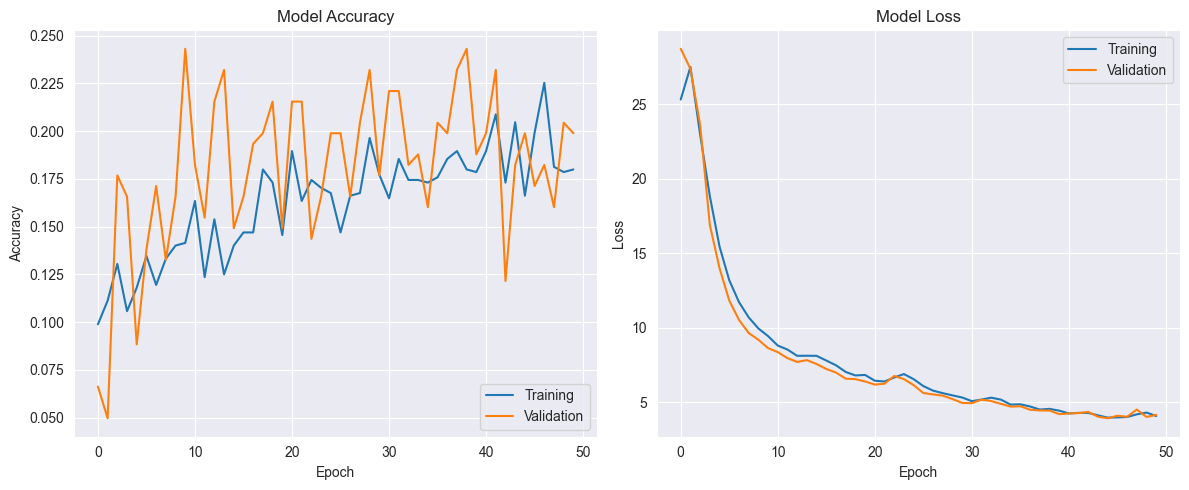

In [14]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('data/cnn_learning.png')
plt.show()

## Test Model

In [15]:
# Test on sample image
test_img_path = "data/B1c.jpg"

img = tf.keras.utils.load_img(
    test_img_path,
    target_size=IMAGE_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
This image most likely belongs to 9 with a 9.94 percent confidence.
